In [1]:
import pandas as pd
import numpy as np
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.offline as py
import warnings
import scipy
from sklearn.model_selection import train_test_split, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
from sklearn.feature_selection import RFE
from xgboost import XGBClassifier
import joblib
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer, ColumnTransformer
warnings.filterwarnings('ignore')

In [2]:
file = "dataset.csv"
dfb = pd.read_csv(file, delimiter = ";")
dfb.head()

,uuid,default,account_amount_added_12_24m,account_days_in_dc_12_24m,account_days_in_rem_12_24m,account_days_in_term_12_24m,account_incoming_debt_vs_paid_0_24m,account_status,account_worst_status_0_3m,account_worst_status_12_24m,...,status_3rd_last_archived_0_24m,status_max_archived_0_6_months,status_max_archived_0_12_months,status_max_archived_0_24_months,recovery_debt,sum_capital_paid_account_0_12m,sum_capital_paid_account_12_24m,sum_paid_inv_0_12m,time_hours,worst_status_active_inv
0,63f69b2c-8b1c-4740-b78d-52ed9a4515ac,0.0,0,0.0,0.0,0.0,0.0,1.0,1.0,NaN,...,1,1,1,1,0,0,0,178839,9.653333,1.0
1,0e961183-8c15-4470-9a5e-07a1bd207661,0.0,0,0.0,0.0,0.0,NaN,1.0,1.0,1.0,...,1,1,2,2,0,0,0,49014,13.181389,NaN
2,d8edaae6-4368-44e0-941e-8328f203e64e,0.0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,...,1,1,2,2,0,0,0,124839,11.561944,1.0
3,0095dfb6-a886-4e2a-b056-15ef45fdb0ef,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,1,1,1,0,0,0,324676,15.751111,1.0
4,c8f8b835-5647-4506-bf15-49105d8af30b,0.0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,...,0,1,1,1,0,0,0,7100,12.698611,NaN


In [3]:
dfb.shape

(99976, 43)

In [4]:
num_columns = ["account_amount_added_12_24m","account_days_in_dc_12_24m","account_days_in_rem_12_24m","account_days_in_term_12_24m","account_incoming_debt_vs_paid_0_24m"
,"age","avg_payment_span_0_12m","avg_payment_span_0_3m","max_paid_inv_0_12m","max_paid_inv_0_24m","num_active_div_by_paid_inv_0_12m","num_active_inv","num_arch_dc_0_12m"
,"num_arch_dc_12_24m","num_arch_ok_0_12m","num_arch_ok_12_24m","num_arch_rem_0_12m","num_arch_written_off_0_12m","num_arch_written_off_12_24m","num_unpaid_bills"
,"recovery_debt","sum_capital_paid_account_0_12m","sum_capital_paid_account_12_24m","sum_paid_inv_0_12m","time_hours"]

cat_columns = ["default","account_status","account_worst_status_0_3m","account_worst_status_12_24m","account_worst_status_3_6m","account_worst_status_6_12m"
,"merchant_category","merchant_group","name_in_email","status_last_archived_0_24m","status_2nd_last_archived_0_24m","status_3rd_last_archived_0_24m"
,"status_max_archived_0_6_months","status_max_archived_0_12_months","status_max_archived_0_24_months","worst_status_active_inv"]

bool_columns = ["has_paid"]

print(len(num_columns),len(cat_columns), len(bool_columns))

25 16 1


In [5]:
dfb[num_columns].describe().T

,count,mean,std,min,25%,50%,75%,max
account_amount_added_12_24m,99976.0,12255.149516,35481.483737,0.000000,0.000000,0.000000,4937.250000,1.128775e+06
account_days_in_dc_12_24m,88140.0,0.223043,5.808117,0.000000,0.000000,0.000000,0.000000,3.650000e+02
account_days_in_rem_12_24m,88140.0,5.044622,22.863971,0.000000,0.000000,0.000000,0.000000,3.650000e+02
account_days_in_term_12_24m,88140.0,0.286896,2.929910,0.000000,0.000000,0.000000,0.000000,9.700000e+01
account_incoming_debt_vs_paid_0_24m,40661.0,1.331292,26.482299,0.000000,0.000000,0.152082,0.662952,3.914000e+03
age,99976.0,36.016284,13.001306,18.000000,25.000000,34.000000,45.000000,1.000000e+02
avg_payment_span_0_12m,76140.0,17.971473,12.751066,0.000000,10.800000,14.909091,21.000000,2.600000e+02
avg_payment_span_0_3m,50671.0,14.989786,10.297420,0.000000,8.400000,13.000000,18.285714,8.700000e+01
max_paid_inv_0_12m,99976.0,9203.654217,13512.167229,0.000000,2000.000000,6052.000000,11380.000000,2.790000e+05
max_paid_inv_0_24m,99976.0,11215.120819,15256.414937,0.000000,3350.000000,7580.000000,13783.000000,5.385000e+05


In [6]:
q = ((dfb.isnull().sum()/ len(dfb))*100)
print(q.sort_values(ascending=False)[:16])

worst_status_active_inv                69.531688
account_worst_status_12_24m            66.777026
account_worst_status_6_12m             60.364487
account_incoming_debt_vs_paid_0_24m    59.329239
account_worst_status_3_6m              57.715852
account_status                         54.386053
account_worst_status_0_3m              54.386053
avg_payment_span_0_3m                  49.316836
avg_payment_span_0_12m                 23.841722
num_active_div_by_paid_inv_0_12m       22.944507
num_arch_written_off_12_24m            18.082340
num_arch_written_off_0_12m             18.082340
account_days_in_rem_12_24m             11.838841
account_days_in_term_12_24m            11.838841
account_days_in_dc_12_24m              11.838841
default                                10.002401
dtype: float64


In [7]:
percent = dfb.isnull().sum() * 100 / len(dfb)
willdrop = percent[percent>30].keys()
dfb = dfb.drop(willdrop, axis=1)
for i in willdrop:
    if i in num_columns:
        num_columns.remove(i)
    elif i in cat_columns:
        cat_columns.remove(i)
    elif i in bool_columns:
        bool_columns.remove(i)


In [8]:
print(len(num_columns),len(cat_columns), len(bool_columns))

23 10 1


In [9]:
q = ((dfb.isnull().sum()/ len(dfb))*100)
print(q.sort_values(ascending=False)[:16])

avg_payment_span_0_12m              23.841722
num_active_div_by_paid_inv_0_12m    22.944507
num_arch_written_off_12_24m         18.082340
num_arch_written_off_0_12m          18.082340
account_days_in_dc_12_24m           11.838841
account_days_in_rem_12_24m          11.838841
account_days_in_term_12_24m         11.838841
default                             10.002401
status_3rd_last_archived_0_24m       0.000000
num_unpaid_bills                     0.000000
status_last_archived_0_24m           0.000000
status_2nd_last_archived_0_24m       0.000000
uuid                                 0.000000
status_max_archived_0_6_months       0.000000
status_max_archived_0_12_months      0.000000
recovery_debt                        0.000000
dtype: float64


In [10]:
from sklearn import preprocessing
 
label_encoder = preprocessing.LabelEncoder()
 
dfb["merchant_category"]= label_encoder.fit_transform(dfb["merchant_category"])
dfb["merchant_group"]= label_encoder.fit_transform(dfb["merchant_group"])
dfb["name_in_email"]= label_encoder.fit_transform(dfb["name_in_email"])
dfb["status_last_archived_0_24m"]= label_encoder.fit_transform(dfb["status_last_archived_0_24m"])
dfb["status_2nd_last_archived_0_24m"]= label_encoder.fit_transform(dfb["status_2nd_last_archived_0_24m"])
dfb["status_3rd_last_archived_0_24m"]= label_encoder.fit_transform(dfb["status_3rd_last_archived_0_24m"])
dfb["status_max_archived_0_6_months"]= label_encoder.fit_transform(dfb["status_max_archived_0_6_months"])
dfb["status_max_archived_0_12_months"]= label_encoder.fit_transform(dfb["status_max_archived_0_12_months"])
dfb["status_max_archived_0_24_months"]= label_encoder.fit_transform(dfb["status_max_archived_0_24_months"])
dfb["has_paid"]= label_encoder.fit_transform(dfb["has_paid"])

In [11]:
predict_data = dfb[pd.isnull(dfb.default)]
predict_data.drop(["uuid"], axis=1, inplace=True)
predict_data.shape

(10000, 34)

In [12]:
dfb.drop(dfb[pd.isnull(dfb.default)].index, axis=0, inplace=True)
dfb.drop(["uuid"], axis=1, inplace=True)
dfb.shape

(89976, 34)

In [13]:
percent = dfb.isnull().sum() * 100 / len(dfb)
missingValuesColumns= percent[percent>0].keys()

In [14]:
def median_target(dataf,var):
    temp=dataf[dataf[var].notnull()]
    temp=temp[[var, 'default']].groupby(['default'])[[var]].median().reset_index()
    return temp

In [15]:
def fill_missing():
    for col in missingValuesColumns :
        dfb.loc[(dfb['default'] == 0.0) & (dfb[col].isnull()), col] = median_target(dfb,col)[col][0]
        dfb.loc[(dfb['default'] == 1.0) & (dfb[col].isnull()), col] = median_target(dfb,col)[col][1]

In [16]:
fill_missing()

In [17]:
dfb[missingValuesColumns].isnull().sum()

account_days_in_dc_12_24m           0
account_days_in_rem_12_24m          0
account_days_in_term_12_24m         0
avg_payment_span_0_12m              0
num_active_div_by_paid_inv_0_12m    0
num_arch_written_off_0_12m          0
num_arch_written_off_12_24m         0
dtype: int64

In [18]:
features=dfb.columns
label = 'default'
X, y = dfb[features].values, dfb[label].values

In [20]:
from imblearn.over_sampling import RandomOverSampler
over_sampler = RandomOverSampler(random_state=42)
X_res, y_res = over_sampler.fit_resample(X, y)


In [21]:
from sklearn.model_selection import train_test_split

# Split data 70%-30% into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.30, random_state=0)

print ('Training cases: %d\nTest cases: %d' % (X_train.shape[0], X_test.shape[0]))

Training cases: 124163
Test cases: 53213


In [22]:
q = (dfb.isnull().sum()/ len(dfb))*100
print(q)

default                             0.0
account_amount_added_12_24m         0.0
account_days_in_dc_12_24m           0.0
account_days_in_rem_12_24m          0.0
account_days_in_term_12_24m         0.0
age                                 0.0
avg_payment_span_0_12m              0.0
merchant_category                   0.0
merchant_group                      0.0
has_paid                            0.0
max_paid_inv_0_12m                  0.0
max_paid_inv_0_24m                  0.0
name_in_email                       0.0
num_active_div_by_paid_inv_0_12m    0.0
num_active_inv                      0.0
num_arch_dc_0_12m                   0.0
num_arch_dc_12_24m                  0.0
num_arch_ok_0_12m                   0.0
num_arch_ok_12_24m                  0.0
num_arch_rem_0_12m                  0.0
num_arch_written_off_0_12m          0.0
num_arch_written_off_12_24m         0.0
num_unpaid_bills                    0.0
status_last_archived_0_24m          0.0
status_2nd_last_archived_0_24m      0.0


In [23]:
# Train the model
from sklearn.linear_model import LogisticRegression

# Set regularization rate
reg = 0.01

# train a logistic regression model on the training set
model = LogisticRegression(C=1/reg, solver="liblinear").fit(X_train, y_train)
print (model)

LogisticRegression(C=100.0, solver='liblinear')


In [24]:
predictions = model.predict(X_test)
print('Predicted labels: ', predictions)
print('Actual labels:    ' ,y_test)

Predicted labels:  [1. 1. 1. ... 0. 1. 0.]
Actual labels:     [1. 1. 1. ... 0. 1. 0.]


In [25]:
from sklearn.metrics import accuracy_score

print('Accuracy: ', accuracy_score(y_test, predictions))

Accuracy:  0.8826226673933062


In [26]:
from sklearn. metrics import classification_report

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         0.0       0.87      0.90      0.88     26358
         1.0       0.89      0.87      0.88     26855

    accuracy                           0.88     53213
   macro avg       0.88      0.88      0.88     53213
weighted avg       0.88      0.88      0.88     53213



In [27]:
from sklearn.metrics import precision_score, recall_score

print("Overall Precision:",precision_score(y_test, predictions))
print("Overall Recall:",recall_score(y_test, predictions))

Overall Precision: 0.8946421048600207
Overall Recall: 0.8698566374976727


In [28]:
from sklearn.metrics import confusion_matrix

# Print the confusion matrix
cm = confusion_matrix(y_test, predictions)
print (cm)

#TN	FP
#FN	TP

[[23607  2751]
 [ 3495 23360]]


In [29]:
y_scores = model.predict_proba(X_test)
print(y_scores)

[[3.05173352e-04 9.99694827e-01]
 [4.50101520e-02 9.54989848e-01]
 [9.62366272e-02 9.03763373e-01]
 ...
 [9.35787732e-01 6.42122682e-02]
 [7.23895961e-02 9.27610404e-01]
 [9.64834496e-01 3.51655036e-02]]


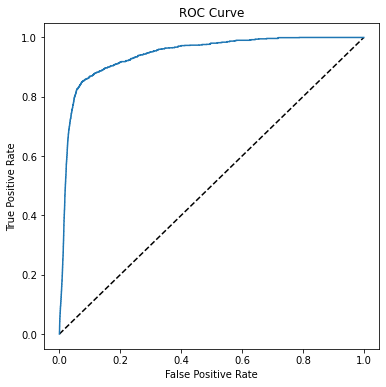

In [30]:
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1])

# plot ROC curve
fig = plt.figure(figsize=(6, 6))
# Plot the diagonal 50% line
plt.plot([0, 1], [0, 1], 'k--')
# Plot the FPR and TPR achieved by our model
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [31]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(y_test,y_scores[:,1])
print('AUC: ' + str(auc))

AUC: 0.9421548197146069


In [32]:
gini = 2*auc - 1
print(gini)

0.8843096394292138


In [33]:
# Train the model
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
import numpy as np

# Define preprocessing for numeric columns (normalize them so they're on the same scale)
numeric_features = [1,2,3,4,5,6,10,11,13,14,15,16,17,18,19,20,21,22,29,30,31,32,33]
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# Define preprocessing for categorical features (encode the Age column)
categorical_features = [7,8,9,12,23,24,26,27,28]
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Create preprocessing and training pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('logregressor', LogisticRegression(C=1/reg, solver="liblinear"))])


# fit the pipeline to train a logistic regression model on the training set
model = pipeline.fit(X_train, (y_train))
print (model)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  [1, 2, 3, 4, 5, 6, 10, 11, 13,
                                                   14, 15, 16, 17, 18, 19, 20,
                                                   21, 22, 29, 30, 31, 32,
                                                   33]),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [7, 8, 9, 12, 23, 24, 26, 27,
                                                   28])])),
                ('logregressor',
                 LogisticRegression(

Confusion Matrix:
 [[23837  2521]
 [ 3494 23361]] 

Accuracy: 0.8869637118749177
Overall Precision: 0.9025963990418051
Overall Recall: 0.8698938745112642
AUC: 0.9449618460471995


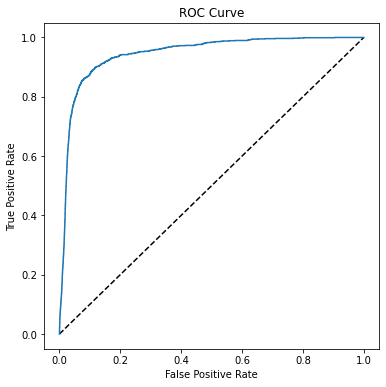

In [34]:
# Get predictions from test data
predictions = model.predict(X_test)
y_scores = model.predict_proba(X_test)

# Get evaluation metrics
cm = confusion_matrix(y_test, predictions)
print ('Confusion Matrix:\n',cm, '\n')
print('Accuracy:', accuracy_score(y_test, predictions))
print("Overall Precision:",precision_score(y_test, predictions))
print("Overall Recall:",recall_score(y_test, predictions))
auc = roc_auc_score(y_test,y_scores[:,1])
print('AUC: ' + str(auc))

# calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1])

# plot ROC curve
fig = plt.figure(figsize=(6, 6))
# Plot the diagonal 50% line
plt.plot([0, 1], [0, 1], 'k--')
# Plot the FPR and TPR achieved by our model
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [35]:
from sklearn.ensemble import RandomForestClassifier

# Create preprocessing and training pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('logregressor', RandomForestClassifier(n_estimators=100))])

# fit the pipeline to train a random forest model on the training set
model = pipeline.fit(X_train, (y_train))
print (model)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  [1, 2, 3, 4, 5, 6, 10, 11, 13,
                                                   14, 15, 16, 17, 18, 19, 20,
                                                   21, 22, 29, 30, 31, 32,
                                                   33]),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [7, 8, 9, 12, 23, 24, 26, 27,
                                                   28])])),
                ('logregressor', RandomForestClassifier())])


Confusion Matrix:
 [[26338    20]
 [    0 26855]] 

Accuracy: 0.9996241519929341
Overall Precision: 0.9992558139534884
Overall Recall: 1.0

AUC: 1.0


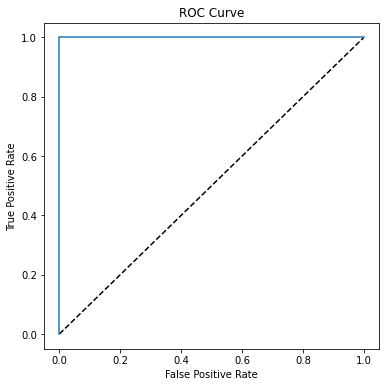

In [36]:
predictions = model.predict(X_test)
y_scores = model.predict_proba(X_test)
cm = confusion_matrix(y_test, predictions)
print ('Confusion Matrix:\n',cm, '\n')
print('Accuracy:', accuracy_score(y_test, predictions))
print("Overall Precision:",precision_score(y_test, predictions))
print("Overall Recall:",recall_score(y_test, predictions))
auc = roc_auc_score(y_test,y_scores[:,1])
print('\nAUC: ' + str(auc))

# calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1])

# plot ROC curve
fig = plt.figure(figsize=(6, 6))
# Plot the diagonal 50% line
plt.plot([0, 1], [0, 1], 'k--')
# Plot the FPR and TPR achieved by our model
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [37]:
import joblib

# Save the model as a pickle file
filename = './denizbank_project_model.pkl'
joblib.dump(model, filename)

['./denizbank_project_model.pkl']

In [38]:
featuress=predict_data.columns
label = 'default'
X2, y2 = predict_data[featuress].values, predict_data[label].values

In [39]:
predict_data["default"] = 0

In [62]:
percent = predict_data.isnull().sum() * 100 / len(predict_data)
missingValuesColumns= percent[percent>0].keys()
missingValuesColumns

Index([], dtype='object')

In [61]:
mean_value=predict_data.mean()
predict_data.fillna(value=mean_value, inplace=True)

In [60]:
predict_data.isnull().sum()

default                             0
account_amount_added_12_24m         0
account_days_in_dc_12_24m           0
account_days_in_rem_12_24m          0
account_days_in_term_12_24m         0
age                                 0
avg_payment_span_0_12m              0
merchant_category                   0
merchant_group                      0
has_paid                            0
max_paid_inv_0_12m                  0
max_paid_inv_0_24m                  0
name_in_email                       0
num_active_div_by_paid_inv_0_12m    0
num_active_inv                      0
num_arch_dc_0_12m                   0
num_arch_dc_12_24m                  0
num_arch_ok_0_12m                   0
num_arch_ok_12_24m                  0
num_arch_rem_0_12m                  0
num_arch_written_off_0_12m          0
num_arch_written_off_12_24m         0
num_unpaid_bills                    0
status_last_archived_0_24m          0
status_2nd_last_archived_0_24m      0
status_3rd_last_archived_0_24m      0
status_max_a

In [57]:
from pickle import load

yuklenen_model = joblib.load(filename)
sonuc = yuklenen_model.score(X2, y2)
print(sonuc)

ValueError: Input X contains NaN.
RandomForestClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values